In [3]:
from pathlib import Path

In [4]:
!cat results/**/results.jsonl > results_combined.jsonl
!wc -l results_combined.jsonl

5670 results_combined.jsonl


In [5]:
import pandas as pd
data = pd.read_json("results_combined.jsonl", lines=True)

In [6]:
data.groupby("predictor").count()["id"]

predictor
claude-2         1890
gpt-3.5-turbo    1890
gpt-4            1890
Name: id, dtype: int64

In [25]:
data.keys()

Index(['id', 'fable_id', 'fable1', 'fable2', 'prediction_raw', 'generator1',
       'generator2', 'prediction', 'correct', 'predictor', 'prompt_fun',
       'correct_prediction'],
      dtype='object')

In [7]:
data.dropna().groupby(["predictor", "prediction", "correct_prediction", ])["prediction"].agg(["count"])

count
predictor     prediction correct_prediction       
claude-2      fable1     fable1                104
                         fable2                102
              fable2     fable1                684
                         fable2                721
              unknown    unknown                12
gpt-3.5-turbo fable1     fable1                835
                         fable2                555
              fable2     fable1                110
                         fable2                390
gpt-4         fable1     fable1                210
                         fable2                463
              fable2     fable1                718
                         fable2                479
              none       none                    3
              unknown    unknown                 5

In [38]:
data.dropna().groupby(["predictor", "generator1", "generator2"])["correct"].agg(["mean"])

mean
predictor     generator1    generator2             
claude-2      claude-2      gpt-3.5-turbo  0.027933
                            gpt-4          0.268966
                            human          0.107527
              gpt-3.5-turbo claude-2       0.909091
                            human          0.089947
              gpt-4         claude-2       0.867052
                            human          0.174603
              human         claude-2       0.920792
                            gpt-3.5-turbo  0.904762
                            gpt-4          0.777778
gpt-3.5-turbo claude-2      gpt-3.5-turbo  0.280423
                            human          0.746032
              gpt-3.5-turbo claude-2       0.984127
                            gpt-4          1.000000
                            human          0.994709
              gpt-4         gpt-3.5-turbo  0.624339
                            human          0.693122
              human         claude-2       0.052910
                            gpt-3.5-turbo  0.973545
                            gpt-4          0.132275
gpt-4         claude-2      gpt-4          0.818182
                            human          0.105820
              gpt-3.5-turbo gpt-4          0.259259
                            human          0.142857
              gpt-4         claude-2       0.276243
                            gpt-3.5-turbo  0.090909
                            human          0.507937
              human         claude-2       0.518519
                            gpt-3.5-turbo  0.476190
                            gpt-4          0.470899

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

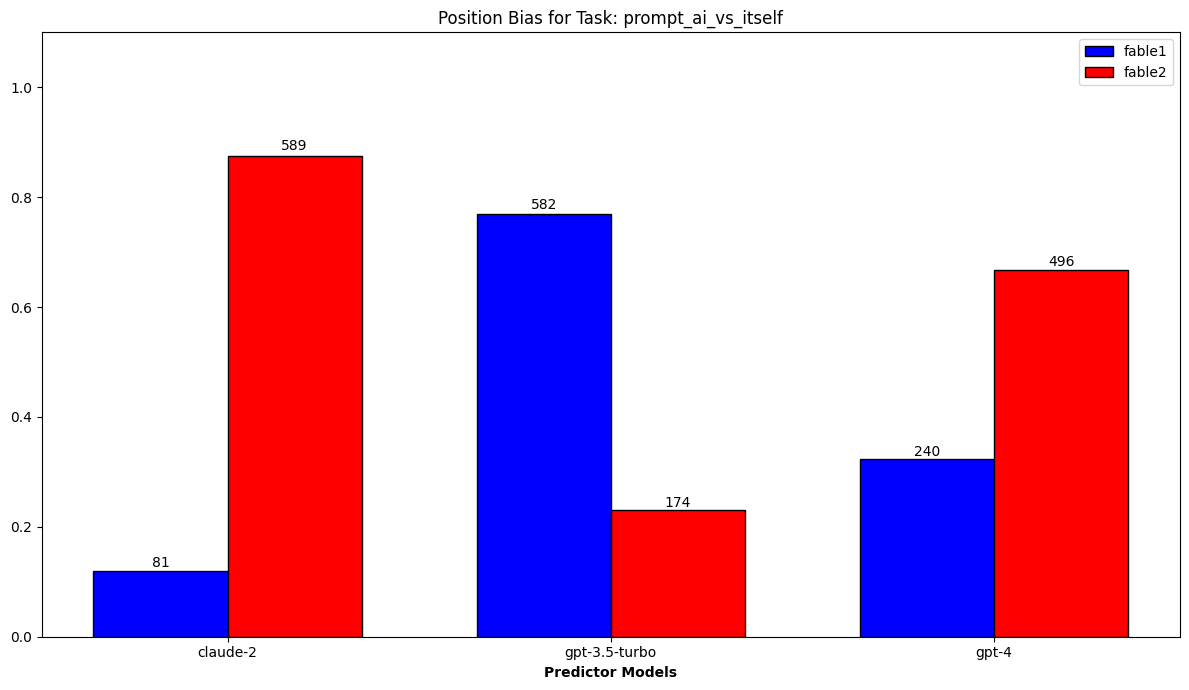

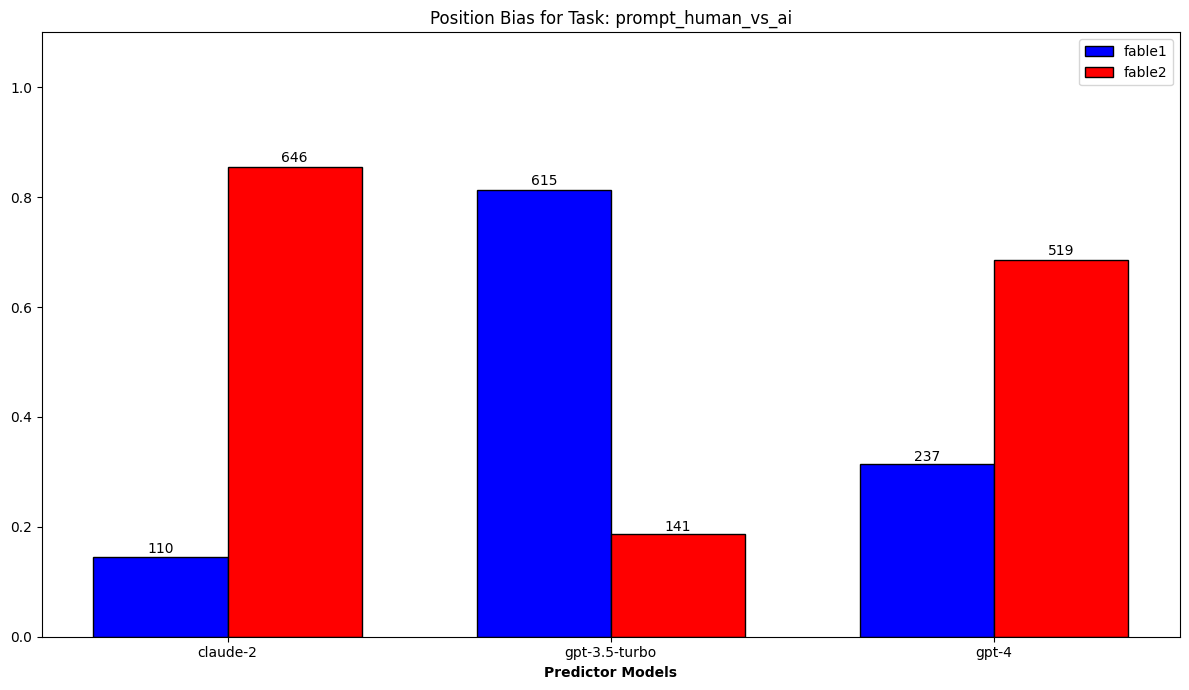

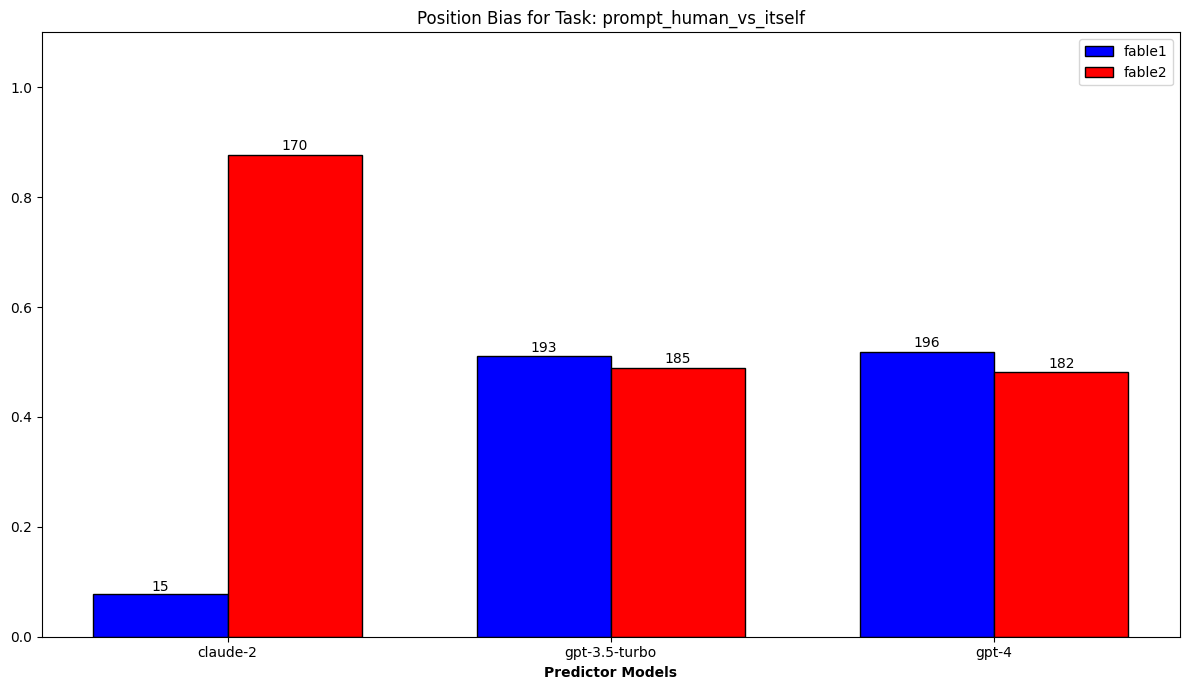

In [79]:

# Compute position bias proportions
position_bias = data.groupby(["predictor", "prompt_fun"])["prediction"].value_counts(normalize=True).reset_index(name="proportion")

# Compute the sample sizes
sample_sizes = data.groupby(["predictor", "prompt_fun"])["prediction"].value_counts().reset_index(name="count")

# Plotting the position bias
for task in position_bias['prompt_fun'].unique():
    sub_data = position_bias[position_bias['prompt_fun'] == task]
    sub_data_count = sample_sizes[sample_sizes['prompt_fun'] == task]
    
    plt.figure(figsize=(12, 7))
    
    # Setting up the bar positions
    bar_width = 0.35
    r1 = np.arange(len(sub_data['predictor'].unique()))
    r2 = [x + bar_width for x in r1]
    
    # Bars for 'fable1' and 'fable2'
    bars1 = []
    bars2 = []
    counts1 = []
    counts2 = []
    for model in sub_data['predictor'].unique():
        model_data = sub_data[sub_data['predictor'] == model]
        model_data_count = sub_data_count[sub_data_count['predictor'] == model]
        bars1.append(model_data[model_data['prediction'] == 'fable1']['proportion'].values[0] if len(model_data[model_data['prediction'] == 'fable1']) > 0 else 0)
        bars2.append(model_data[model_data['prediction'] == 'fable2']['proportion'].values[0] if len(model_data[model_data['prediction'] == 'fable2']) > 0 else 0)
        counts1.append(model_data_count[model_data_count['prediction'] == 'fable1']['count'].values[0] if len(model_data_count[model_data_count['prediction'] == 'fable1']) > 0 else 0)
        counts2.append(model_data_count[model_data_count['prediction'] == 'fable2']['count'].values[0] if len(model_data_count[model_data_count['prediction'] == 'fable2']) > 0 else 0)
    
    # Create bars
    bar1 = plt.bar(r1, bars1, width=bar_width, label='fable1', color='blue', edgecolor='black')
    bar2 = plt.bar(r2, bars2, width=bar_width, label='fable2', color='red', edgecolor='black')
    
    # Add the counts as labels on top of the bars
    for idx, rect in enumerate(bar1):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.005*height, f'{counts1[idx]}', ha='center', va='bottom')
        
    for idx, rect in enumerate(bar2):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.005*height, f'{counts2[idx]}', ha='center', va='bottom')
    
    # General layout
    plt.xlabel('Predictor Models', fontweight='bold')
    plt.xticks([r + bar_width /2 for r in range(len(bars1))], sub_data['predictor'].unique())
    plt.title(f"Position Bias for Task: {task}")
    plt.ylim(0, 1.1)  # Adjusting y limit to fit counts
    plt.legend()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

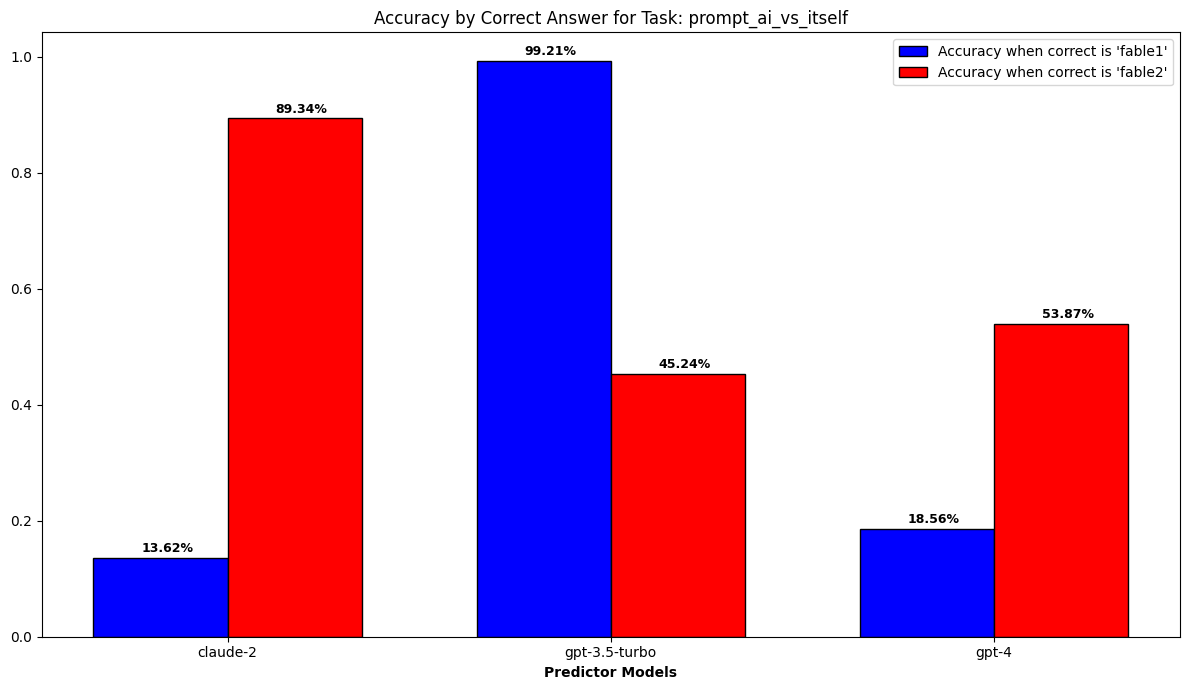

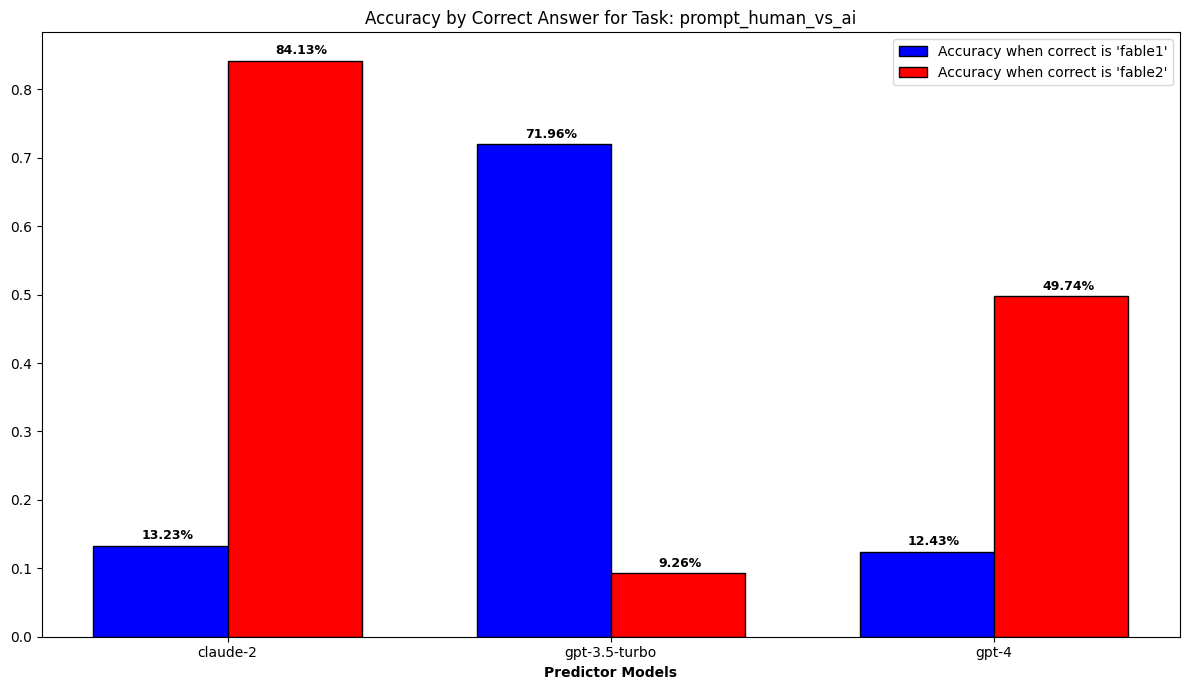

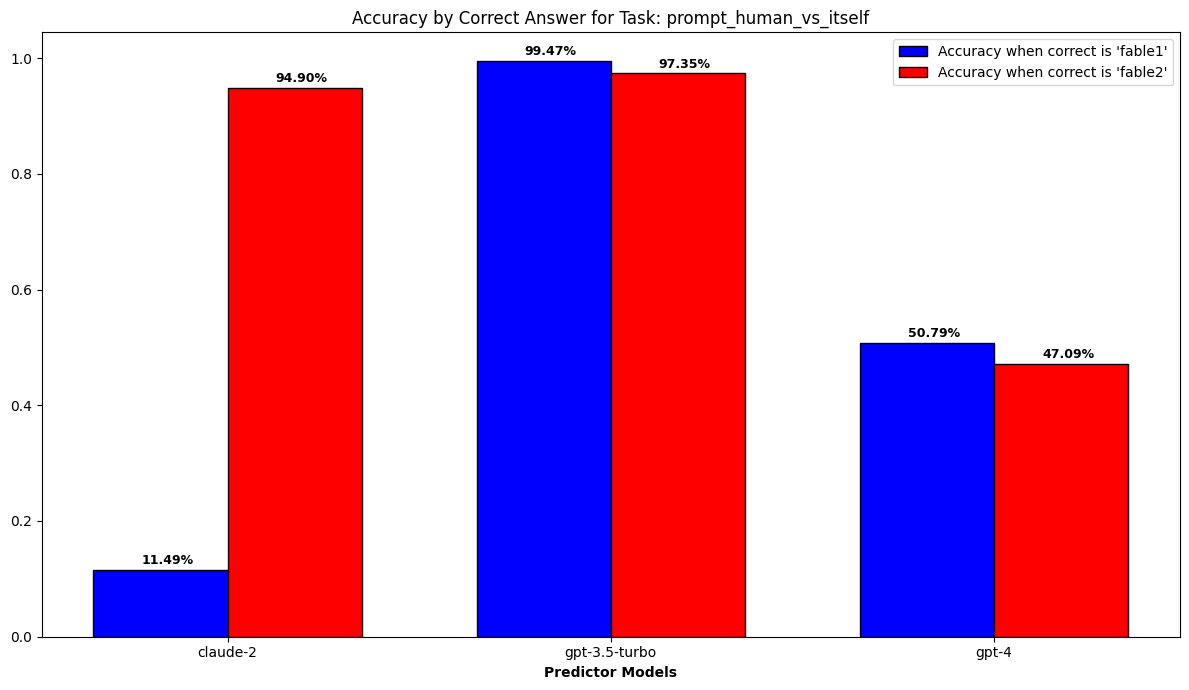

In [80]:

# Compute accuracy
accuracy_data = data.groupby(['predictor', 'prompt_fun', 'correct_prediction']).correct.mean().reset_index()

# Plotting
for task in accuracy_data['prompt_fun'].unique():
    sub_data = accuracy_data[accuracy_data['prompt_fun'] == task]
    
    plt.figure(figsize=(12, 7))
    bar_width = 0.35
    r1 = np.arange(len(sub_data['predictor'].unique()))
    r2 = [x + bar_width for x in r1]
    
    # Bars for accuracies when correct answer is 'fable1' and 'fable2'
    bars1 = []
    bars2 = []
    for model in sub_data['predictor'].unique():
        model_data = sub_data[sub_data['predictor'] == model]
        bars1.append(model_data[model_data['correct_prediction'] == 'fable1']['correct'].values[0] if len(model_data[model_data['correct_prediction'] == 'fable1']) > 0 else 0)
        bars2.append(model_data[model_data['correct_prediction'] == 'fable2']['correct'].values[0] if len(model_data[model_data['correct_prediction'] == 'fable2']) > 0 else 0)
    
    plt.bar(r1, bars1, width=bar_width, label="Accuracy when correct is 'fable1'", color='blue', edgecolor='black')
    plt.bar(r2, bars2, width=bar_width, label="Accuracy when correct is 'fable2'", color='red', edgecolor='black')
    
    # Add the exact percentages on top of the bars
    for i, bar in enumerate(bars1):
        plt.text(r1[i] - 0.05, bar + 0.01, f"{bar:.2%}", fontsize=9, fontweight='bold')
        
    for i, bar in enumerate(bars2):
        plt.text(r2[i] - 0.05, bar + 0.01, f"{bar:.2%}", fontsize=9, fontweight='bold')
    
    plt.xlabel('Predictor Models', fontweight='bold')
    plt.xticks([r + bar_width / 2 for r in range(len(bars1))], sub_data['predictor'].unique())
    plt.title(f"Accuracy by Correct Answer for Task: {task}")
    plt.legend()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

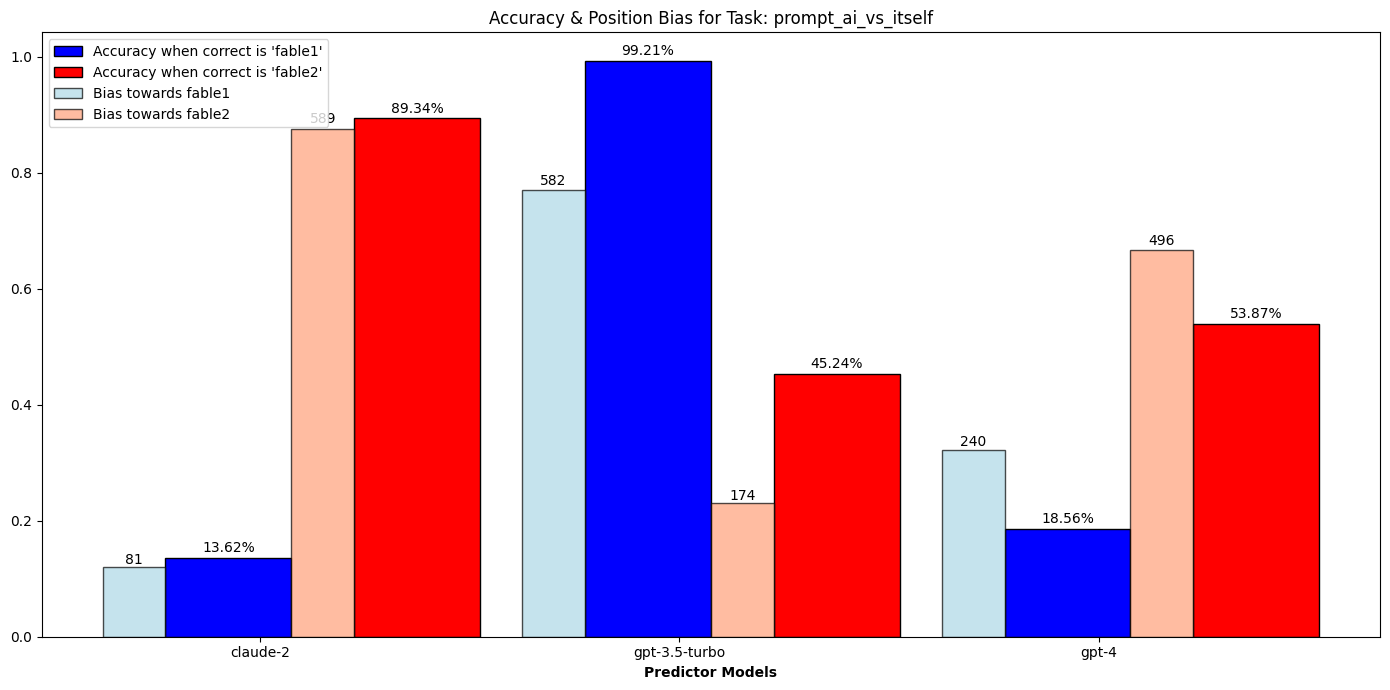

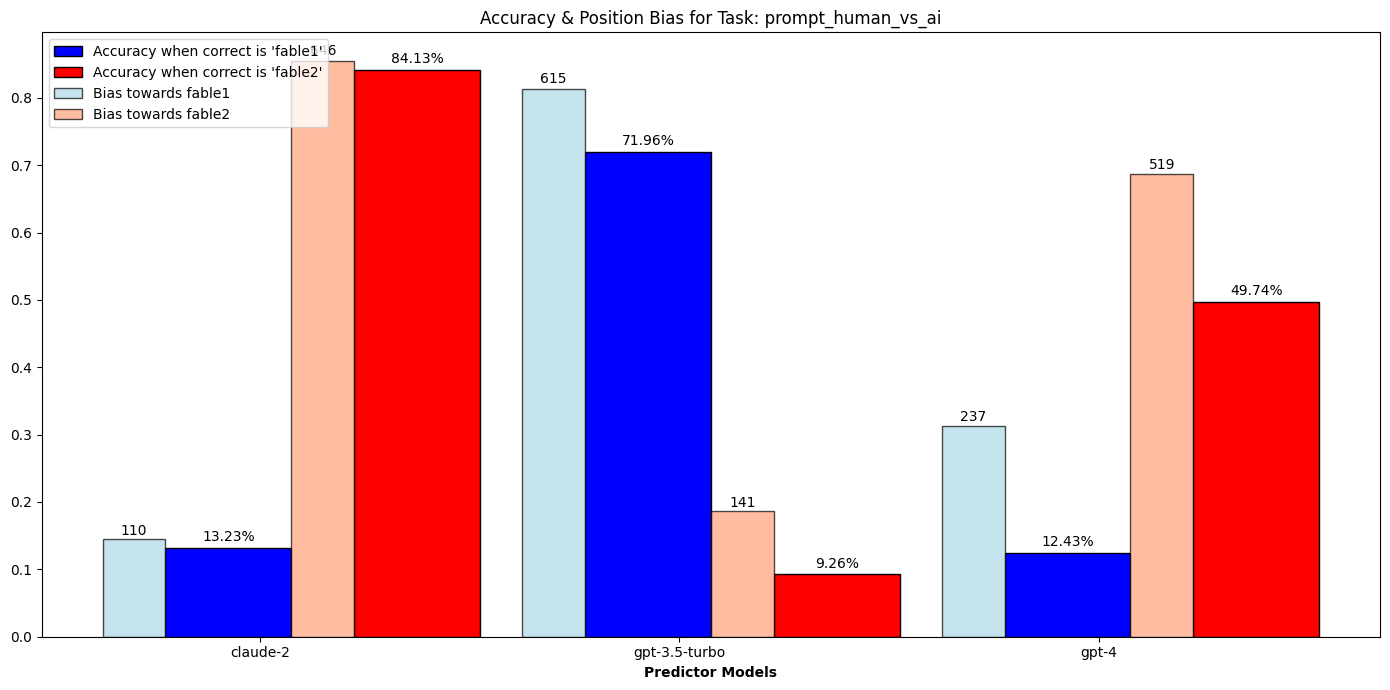

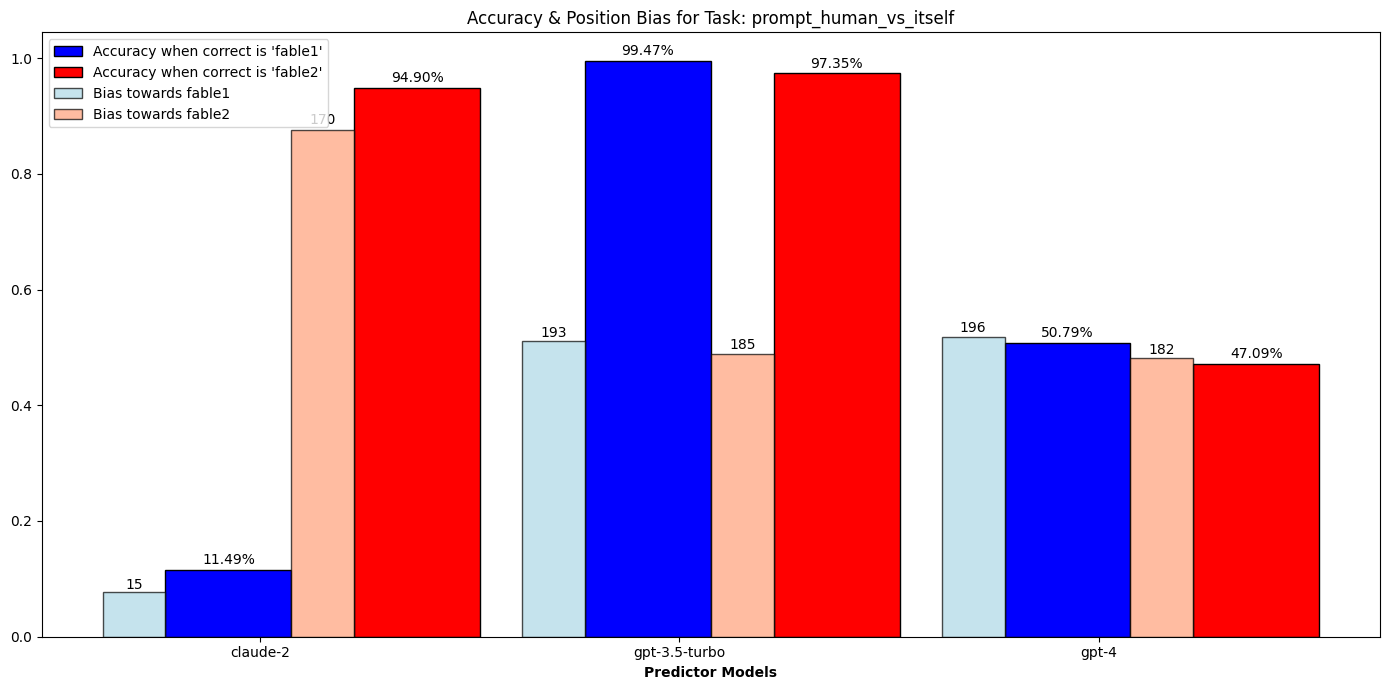

In [94]:
position_bias = data.groupby(["predictor", "prompt_fun"])["prediction"].value_counts(normalize=True).reset_index(name="proportion")
sample_sizes = data.groupby(["predictor", "prompt_fun"])["prediction"].value_counts().reset_index(name="count")
accuracy_data = data.groupby(['predictor', 'prompt_fun', 'correct_prediction']).correct.mean().reset_index()

tasks = position_bias['prompt_fun'].unique()
bar_width = 0.3

for task in tasks:
    plt.figure(figsize=(14, 7))
    
    # Accuracy Data Preparation
    sub_data_accuracy = accuracy_data[accuracy_data['prompt_fun'] == task]
    models = sub_data_accuracy['predictor'].unique()
    r = np.arange(len(models))
    bars1_accuracy, bars2_accuracy = [], []
    
    for model in models:
        model_data = sub_data_accuracy[sub_data_accuracy['predictor'] == model]
        bars1_accuracy.append(model_data[model_data['correct_prediction'] == 'fable1']['correct'].values[0] if 'fable1' in model_data['correct_prediction'].values else 0)
        bars2_accuracy.append(model_data[model_data['correct_prediction'] == 'fable2']['correct'].values[0] if 'fable2' in model_data['correct_prediction'].values else 0)

    plt.bar(r - 0.25*bar_width, bars1_accuracy, width=bar_width, color='blue', edgecolor='black', label="Accuracy when correct is 'fable1'")
    plt.bar(r + 1.25*bar_width, bars2_accuracy, width=bar_width, color='red', edgecolor='black', label="Accuracy when correct is 'fable2'")

    # Labels for accuracy percentages
    for i, bar in enumerate(bars1_accuracy):
        plt.text(r[i] - 0.25*bar_width, bar + 0.01, f"{bar:.2%}", ha='center')
    for i, bar in enumerate(bars2_accuracy):
        plt.text(r[i] + 1.25*bar_width, bar + 0.01, f"{bar:.2%}", ha='center')

    # Position Bias Data Preparation
    sub_data_bias = position_bias[position_bias['prompt_fun'] == task]
    sub_data_count = sample_sizes[sample_sizes['prompt_fun'] == task]

    bars1_bias, bars2_bias, counts1, counts2 = [], [], [], []
    for model in models:
        model_data = sub_data_bias[sub_data_bias['predictor'] == model]
        model_data_count = sub_data_count[sub_data_count['predictor'] == model]
        
        bars1_bias.append(model_data[model_data['prediction'] == 'fable1']['proportion'].values[0] if 'fable1' in model_data['prediction'].values else 0)
        bars2_bias.append(model_data[model_data['prediction'] == 'fable2']['proportion'].values[0] if 'fable2' in model_data['prediction'].values else 0)
        
        counts1.append(model_data_count[model_data_count['prediction'] == 'fable1']['count'].values[0] if 'fable1' in model_data_count['prediction'].values else 0)
        counts2.append(model_data_count[model_data_count['prediction'] == 'fable2']['count'].values[0] if 'fable2' in model_data_count['prediction'].values else 0)
    
    bar1_bias = plt.bar(r - 1*bar_width, bars1_bias, width=bar_width / 2, color='lightblue', edgecolor='black', alpha=0.7, label="Bias towards fable1")
    bar2_bias = plt.bar(r + 0.5*bar_width, bars2_bias, width=bar_width / 2, color='lightsalmon', edgecolor='black', alpha=0.7, label="Bias towards fable2")

    # Labels for sample sizes on bias bars
    for idx, rect in enumerate(bar1_bias):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.005*height, f"{counts1[idx]}", ha='center', va='bottom')
        
    for idx, rect in enumerate(bar2_bias):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.005*height, f"{counts2[idx]}", ha='center', va='bottom')

    plt.xlabel('Predictor Models', fontweight='bold')
    plt.xticks(r, models)
    plt.title(f"Accuracy & Position Bias for Task: {task}")
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

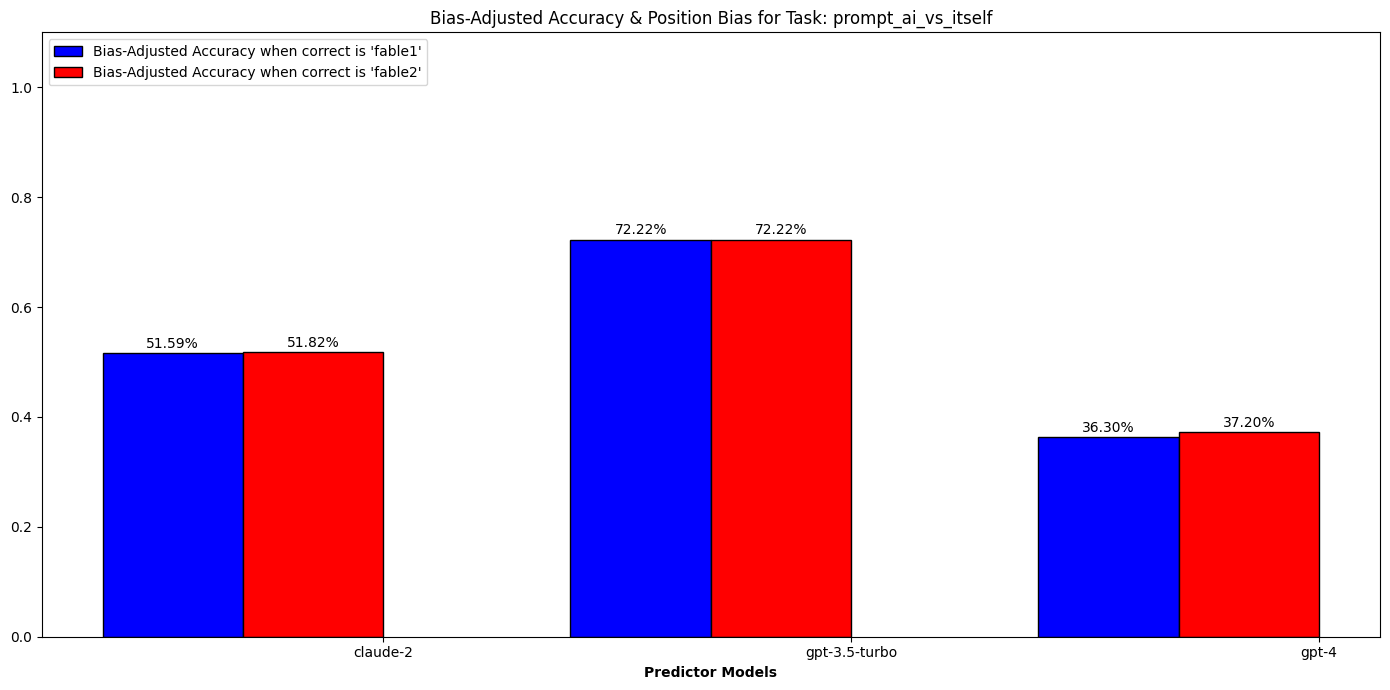

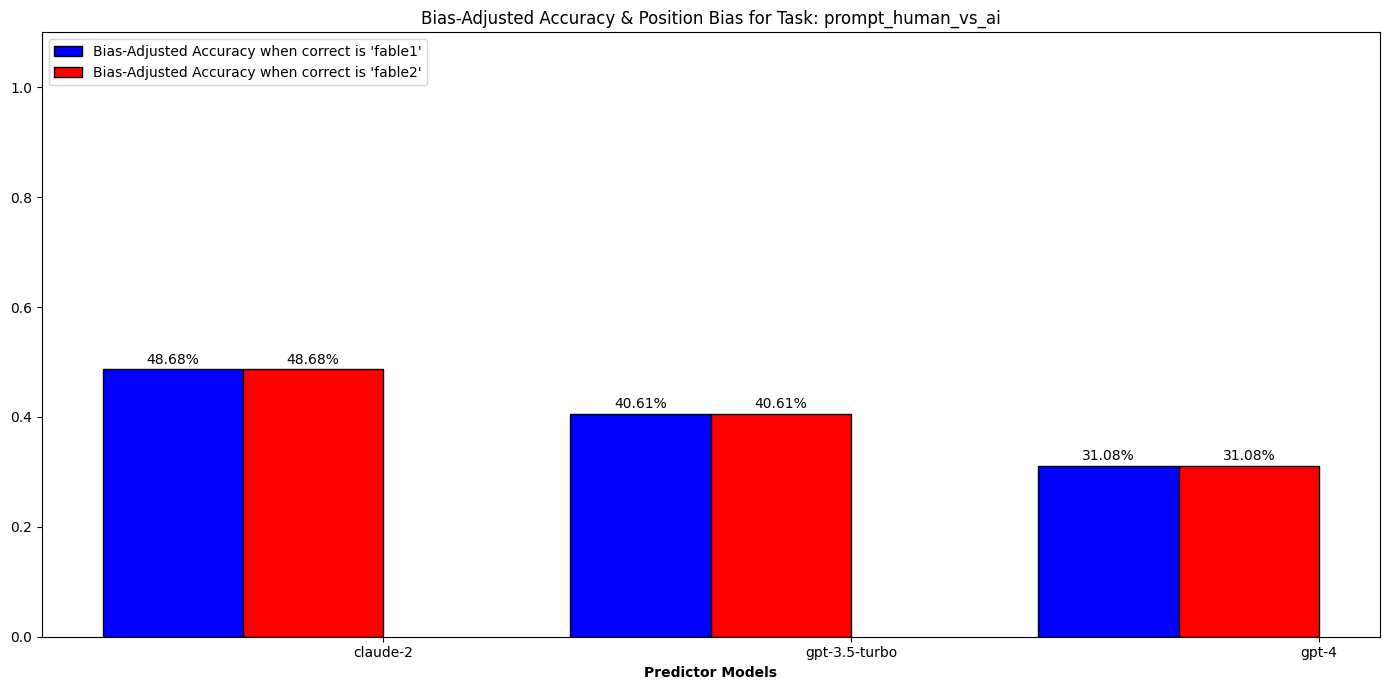

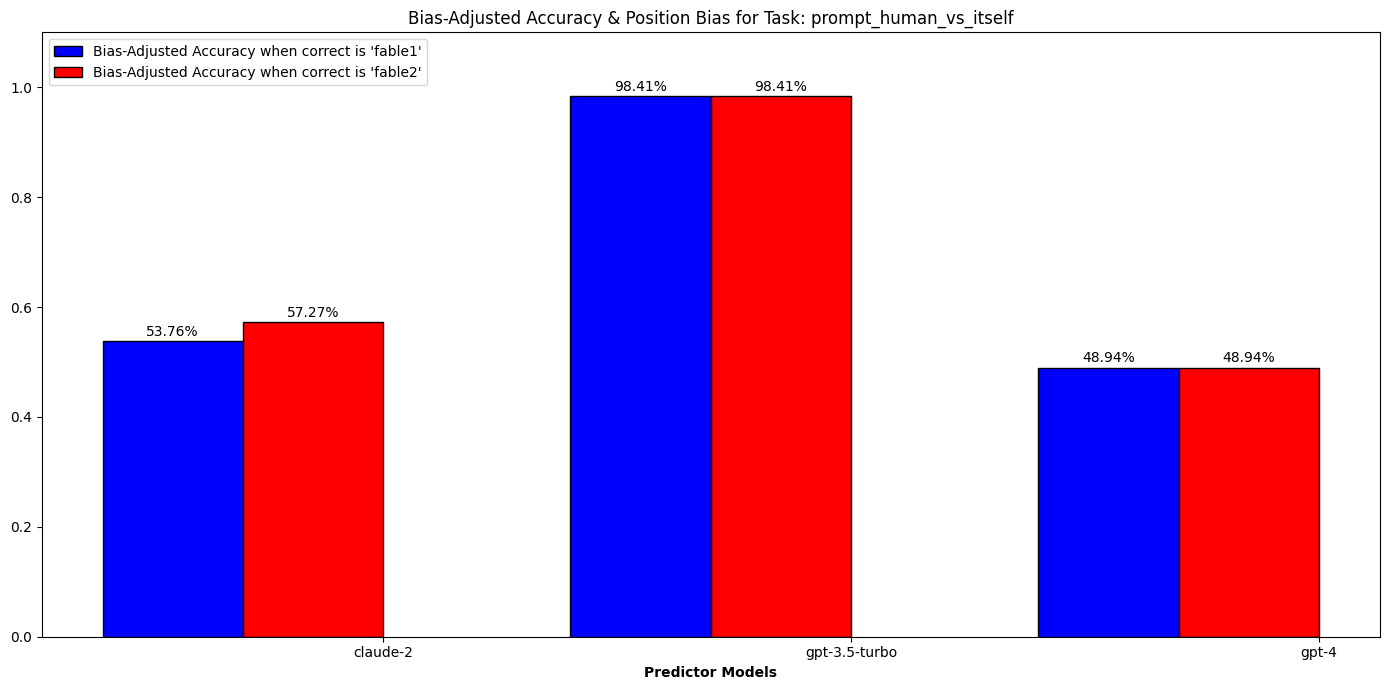

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample data definition for context; Replace with actual data loading step
# data = pd.read_csv('your_dataset.csv')

# Compute necessary dataframes
position_bias = data.groupby(["predictor", "prompt_fun"])["prediction"].value_counts(normalize=True).reset_index(name="proportion")
sample_sizes = data.groupby(["predictor", "prompt_fun"])["prediction"].value_counts().reset_index(name="count")
accuracy_data = data.groupby(['predictor', 'prompt_fun', 'correct_prediction']).correct.mean().reset_index()

tasks = position_bias['prompt_fun'].unique()
bar_width = 0.3
bias_bar_width = 0.15

for task in tasks:
    plt.figure(figsize=(14, 7))
    
    # Accuracy Data Preparation
    sub_data_accuracy = accuracy_data[accuracy_data['prompt_fun'] == task]
    sub_data_bias = position_bias[position_bias['prompt_fun'] == task]
    
    models = sub_data_accuracy['predictor'].unique()
    r = np.arange(len(models))
    bars1_accuracy_adj, bars2_accuracy_adj = [], []
    
    for model in models:
        model_data_acc = sub_data_accuracy[sub_data_accuracy['predictor'] == model]
        model_data_bias = sub_data_bias[sub_data_bias['predictor'] == model]
        
        raw_acc_fable1 = model_data_acc[model_data_acc['correct_prediction'] == 'fable1']['correct'].values[0] if 'fable1' in model_data_acc['correct_prediction'].values else 0
        raw_acc_fable2 = model_data_acc[model_data_acc['correct_prediction'] == 'fable2']['correct'].values[0] if 'fable2' in model_data_acc['correct_prediction'].values else 0
        
        bias_fable1 = model_data_bias[model_data_bias['prediction'] == 'fable1']['proportion'].values[0] if 'fable1' in model_data_bias['prediction'].values else 0.5
        bias_fable2 = model_data_bias[model_data_bias['prediction'] == 'fable2']['proportion'].values[0] if 'fable2' in model_data_bias['prediction'].values else 0.5
        
        bars1_accuracy_adj.append(raw_acc_fable1 - (bias_fable1 - 0.5))
        bars2_accuracy_adj.append(raw_acc_fable2 - (bias_fable2 - 0.5))

    plt.bar(r - 1.5*bar_width, bars1_accuracy_adj, width=bar_width, color='blue', edgecolor='black', label="Bias-Adjusted Accuracy when correct is 'fable1'")
    plt.bar(r - 0.5*bar_width, bars2_accuracy_adj, width=bar_width, color='red', edgecolor='black', label="Bias-Adjusted Accuracy when correct is 'fable2'")

    # Labels for adjusted accuracy percentages
    for i, bar in enumerate(bars1_accuracy_adj):
        plt.text(r[i] - 1.5*bar_width, bar + 0.01, f"{bar:.2%}", ha='center')
    for i, bar in enumerate(bars2_accuracy_adj):
        plt.text(r[i] - 0.5*bar_width, bar + 0.01, f"{bar:.2%}", ha='center')
    
    # Other components of the graph (position bias bars, labels, etc.) remain unchanged...

    plt.xlabel('Predictor Models', fontweight='bold')
    plt.xticks(r, models)
    plt.title(f"Bias-Adjusted Accuracy & Position Bias for Task: {task}")
    plt.legend(loc='upper left')
    
    plt.ylim(0, 1.1)

    plt.tight_layout()
    plt.show()

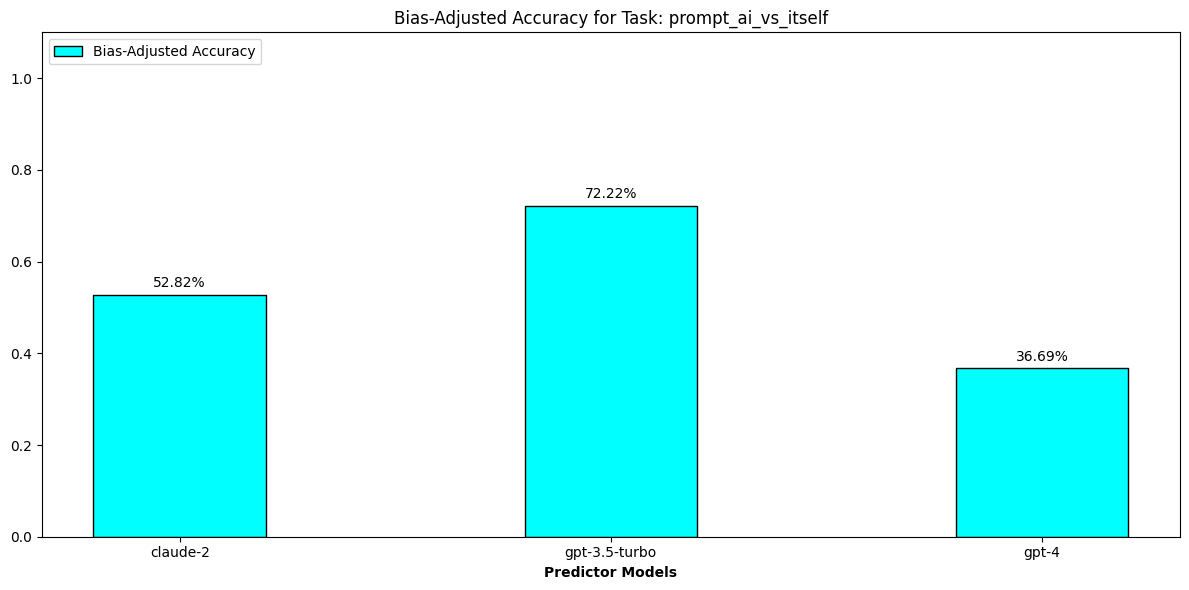

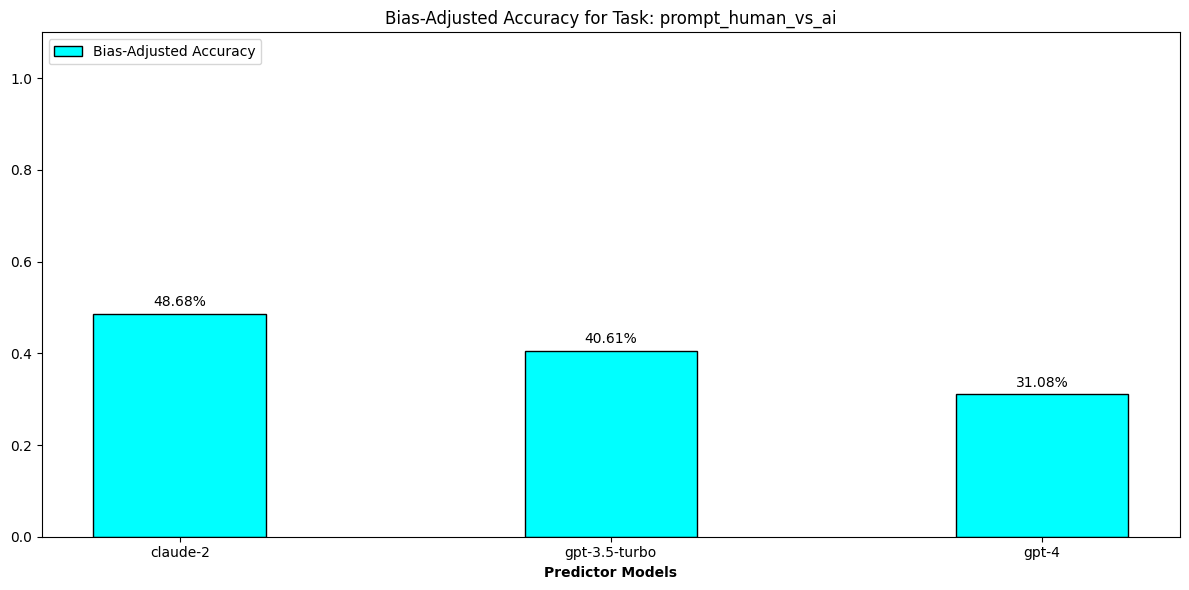

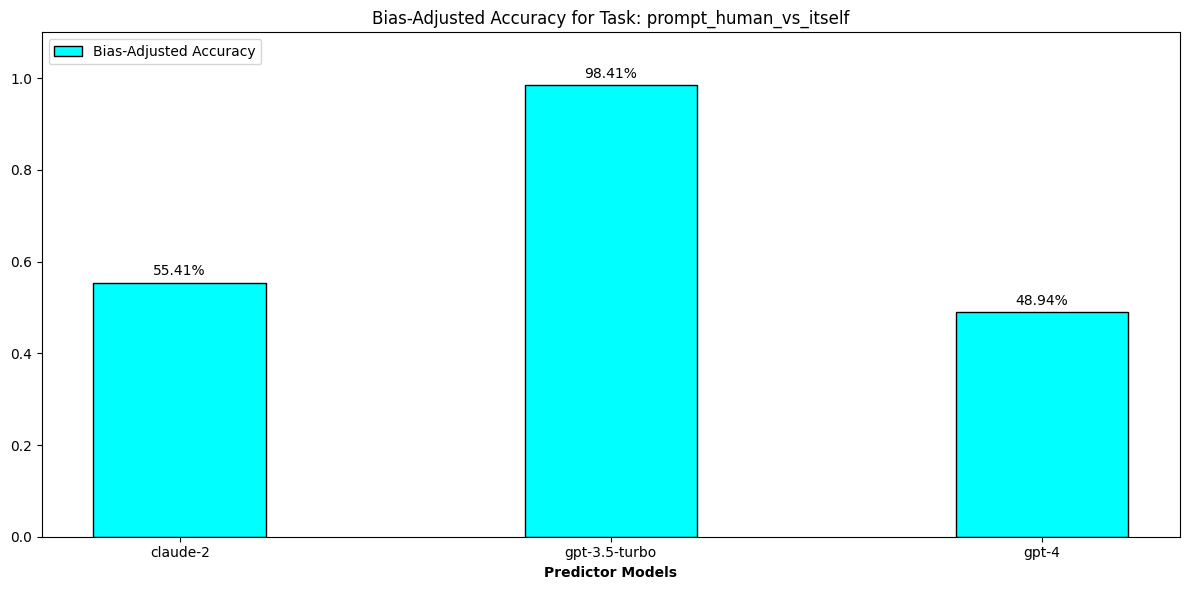

In [102]:

# Compute necessary dataframes
position_bias = data.groupby(["predictor", "prompt_fun"])["prediction"].value_counts(normalize=True).reset_index(name="proportion")
accuracy_data = data.groupby(['predictor', 'prompt_fun']).correct.mean().reset_index()

tasks = position_bias['prompt_fun'].unique()
bar_width = 0.4

for task in tasks:
    plt.figure(figsize=(12, 6))
    
    # Accuracy Data Preparation
    sub_data_accuracy = accuracy_data[accuracy_data['prompt_fun'] == task]
    sub_data_bias = position_bias[position_bias['prompt_fun'] == task]
    
    models = sub_data_accuracy['predictor'].unique()
    r = np.arange(len(models))
    accuracy_adj = []
    
    for model in models:
        model_data_acc = sub_data_accuracy[sub_data_accuracy['predictor'] == model]
        model_data_bias = sub_data_bias[sub_data_bias['predictor'] == model]
        
        raw_acc = model_data_acc['correct'].values[0]
        
        bias_fable1 = model_data_bias[model_data_bias['prediction'] == 'fable1']['proportion'].values[0] if 'fable1' in model_data_bias['prediction'].values else 0.5
        bias_fable2 = model_data_bias[model_data_bias['prediction'] == 'fable2']['proportion'].values[0] if 'fable2' in model_data_bias['prediction'].values else 0.5
        avg_bias = (bias_fable1 + bias_fable2) / 2
        
        accuracy_adj.append(raw_acc - (avg_bias - 0.5))

    bars = plt.bar(r, accuracy_adj, width=bar_width, color='cyan', edgecolor='black', label="Bias-Adjusted Accuracy")

    # Labels for adjusted accuracy percentages
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(r[i], height + 0.01, f"{accuracy_adj[i]:.2%}", ha='center', va='bottom')
    
    plt.xlabel('Predictor Models', fontweight='bold')
    plt.xticks(r, models)
    plt.title(f"Bias-Adjusted Accuracy for Task: {task}")
    plt.ylim(0, max(accuracy_adj) + 0.1)  # Adjusting y limit to fit labels
    plt.legend(loc='upper left')
    
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()